In [5]:
!pip install hmmlearn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\Semhane\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
!pip install torch


   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 1.8/212.5 MB 16.7 MB/s eta 0:00:13
   - -------------------------------------- 10.5/212.5 MB 32.7 MB/s eta 0:00:07
   --- ------------------------------------ 19.4/212.5 MB 36.0 MB/s eta 0:00:06
   ----- ---------------------------------- 28.0/212.5 MB 38.6 MB/s eta 0:00:05
   ------ --------------------------------- 36.7/212.5 MB 38.8 MB/s eta 0:00:05
   -------- ------------------------------- 44.0/212.5 MB 38.4 MB/s eta 0:00:05
   ---------- ----------------------------- 58.2/212.5 MB 42.6 MB/s eta 0:00:04
   ------------- -------------------------- 70.5/212.5 MB 45.9 MB/s eta 0:00:04
   -------------- ------------------------- 75.5/212.5 MB 42.6 MB/s eta 0:00:04
   --------------- ------------------------ 81.5/212.5 MB 42.6 MB/s eta 0:00:04
   ---------------- ----------------------- 88.6/212.5 MB 40.1 MB/s eta 0:00:04
   ------------------ --------------------- 96.5/2


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\Semhane\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # GridSearchCV removed for now
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

# New models to import
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Existing models for time series
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary # Make sure this is installed: pip install torchsummary

from scipy.fftpack import fft
import pywt

In [53]:
# ==== Load data ====
train_df = pd.read_csv('Sleep Train 5000.csv', header=None)
test_df = pd.read_csv('Sleep Test 1000.csv', header=None)

In [54]:
# ==== EDA and Visualization (using full raw training data before splits) ====
X_train_full_viz = train_df.iloc[:, 1:].values
y_train_full_viz = train_df.iloc[:, 0].values

def explore_data(df, name="Dataset"):
    print(f"=== {name} Exploration ===")
    print(f"Shape: {df.shape}")
    class_counts = df[0].value_counts()
    print(f"\nClass distribution:")
    print(class_counts)
    print(f"Number of unique classes: {len(class_counts)}")
    print(f"\nMissing values: {df.isnull().sum().sum()}")
    print(f"\nBasic statistics of first few features:")
    print(df.iloc[:, 1:6].describe())
    return class_counts

train_classes_counts = explore_data(train_df, "Training Data")

=== Training Data Exploration ===
Shape: (4999, 179)

Class distribution:
0
2    2000
3    1040
4     751
1     697
0     511
Name: count, dtype: int64
Number of unique classes: 5

Missing values: 0

Basic statistics of first few features:
                 1            2            3            4            5
count  4999.000000  4999.000000  4999.000000  4999.000000  4999.000000
mean     -0.554607    -0.564193    -0.540193    -0.649433    -0.753712
std      17.789305    17.597088    17.681466    17.723401    17.403211
min    -146.094760   -82.371185   -81.849570   -90.543100   -90.803910
25%      -9.345543    -9.258608    -9.519414    -9.693284    -9.432479
50%      -0.391209    -0.652015    -0.652015    -0.738950    -0.738950
75%       8.062149     8.041514     8.215385     8.215385     7.883883
max     105.409035    95.585350    91.934070   109.668860    87.065690


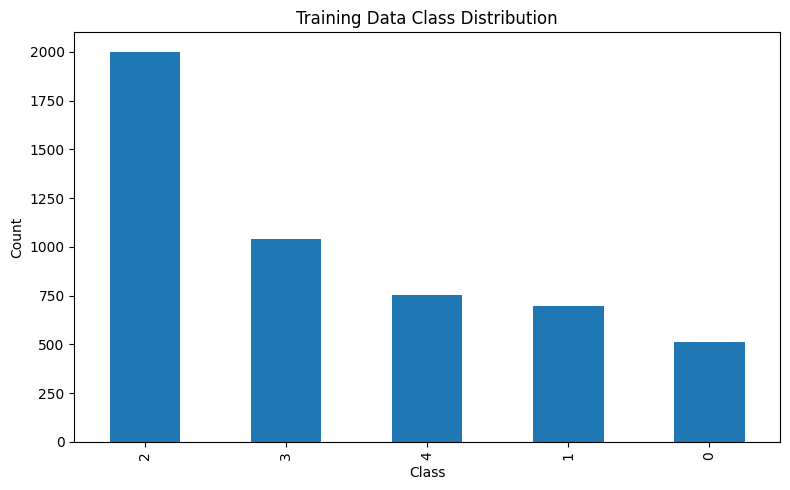

In [55]:
# Visualize class distribution (Optional - comment out if not needed repeatedly)
plt.figure(figsize=(8, 5))
train_classes_counts.plot(kind='bar')
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

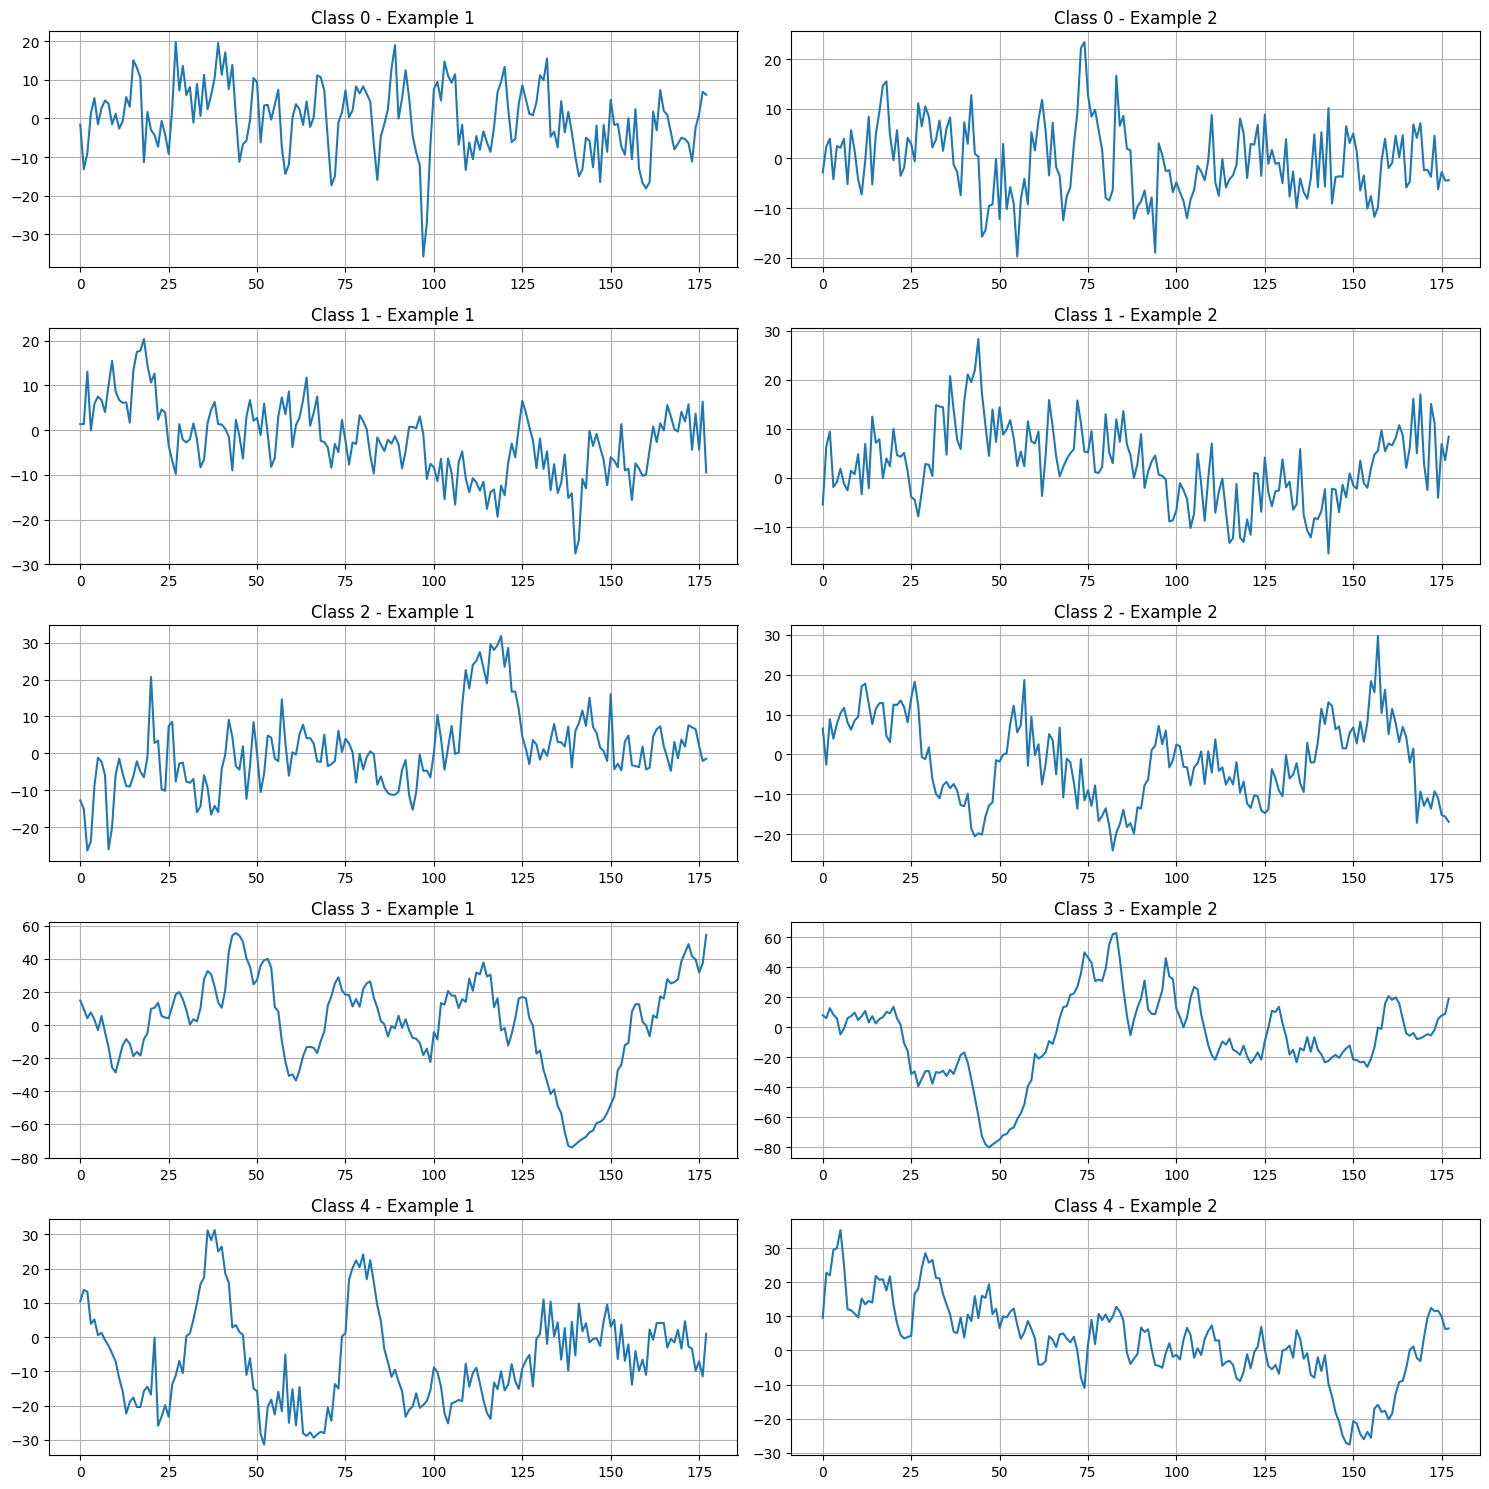

In [56]:
# Visualize a few examples from each class (Optional - comment out if not needed repeatedly)
def plot_examples(X, y, n_examples=2):
    classes = np.unique(y)
    plt.figure(figsize=(15, len(classes)*3))
    for i, cls in enumerate(classes):
        class_indices = np.where(y == cls)[0]
        n_to_plot = min(n_examples, len(class_indices))
        indices_to_plot = class_indices[:n_to_plot]
        for j, idx in enumerate(indices_to_plot):
            plt.subplot(len(classes), n_examples, i*n_examples + j + 1)
            plt.plot(X[idx])
            plt.title(f'Class {cls} - Example {j+1}')
            plt.grid(True)
    plt.tight_layout()
    plt.savefig('class_examples.png')
    plt.show()
plot_examples(X_train_full_viz, y_train_full_viz)


In [57]:
# --- Custom Feature Extraction Functions ---
def extract_stats(X_data):
    features = []
    for signal in X_data:
        mean = np.mean(signal); std = np.std(signal); var = np.var(signal)
        mini = np.min(signal); maxi = np.max(signal); rng = maxi - mini
        median = np.median(signal); skew = 0; kurtosis = 0
        if std > 0:
            skew = np.mean(((signal - mean) / std) ** 3)
            kurtosis = np.mean(((signal - mean) / std) ** 4) - 3
        zero_crossings = np.sum(np.diff(np.signbit(signal - np.mean(signal))))
        peaks = np.sum(np.diff(np.signbit(np.diff(signal))) < 0)
        diffs = np.diff(signal)
        mean_diff = np.mean(diffs) if len(diffs) > 0 else 0
        std_diff = np.std(diffs) if len(diffs) > 0 else 0
        energy = np.sum(signal ** 2); power = energy / len(signal) if len(signal) > 0 else 0
        q25 = np.percentile(signal, 25); q75 = np.percentile(signal, 75); iqr = q75 - q25
        feat = [mean, std, var, mini, maxi, rng, median, skew, kurtosis,
                zero_crossings, peaks, mean_diff, std_diff, energy, power, q25, q75, iqr]
        features.append(feat)
    return np.array(features)

def extract_fft_features(X_data, n_coeffs=50):
    features = []
    for signal in X_data:
        fft_values = np.abs(fft(signal)); dominant_freqs = fft_values[:n_coeffs]
        total_power = np.sum(fft_values ** 2) if np.sum(fft_values ** 2) > 0 else 1
        n_bands = 5; band_size = len(fft_values) // n_bands; band_powers = []
        for i in range(n_bands):
            start = i * band_size; end = (i + 1) * band_size if i < n_bands - 1 else len(fft_values)
            band_power = np.sum(fft_values[start:end] ** 2) / total_power
            band_powers.append(band_power)
        fft_mean = np.mean(fft_values); fft_std = np.std(fft_values)
        fft_max = np.max(fft_values); fft_peak_idx = np.argmax(fft_values)
        feat = np.concatenate([dominant_freqs, band_powers, [fft_mean, fft_std, fft_max, fft_peak_idx]])
        features.append(feat)
    return np.array(features)

def extract_wavelet_features(X_data, wavelet='db4', level=4):
    features = []
    for signal in X_data:
        try:
            coeffs = pywt.wavedec(signal, wavelet, level=level)
        except ValueError: # Simplified error handling for brevity
            wavelet_features = [0.0] * (level + 1) * 3 # Ensure consistent length
        else:
            wavelet_features = []
            for coef in coeffs:
                if len(coef) == 0: wavelet_features.extend([0,0,0]); continue
                wavelet_features.extend([np.mean(coef), np.std(coef), np.sum(coef ** 2)])
        features.append(wavelet_features)
    if features:
        max_len = max(len(f) for f in features)
        features = [f + [0.0] * (max_len - len(f)) if len(f) < max_len else f for f in features]
    return np.array(features)

In [58]:
# ==== Data Preparation ====
X_all_train_raw = train_df.iloc[:, 1:].values
y_all_train_raw = train_df.iloc[:, 0].values
X_test_full_raw = test_df.values

if X_test_full_raw.shape[1] < X_all_train_raw.shape[1]:
    padding = np.zeros((X_test_full_raw.shape[0], X_all_train_raw.shape[1] - X_test_full_raw.shape[1]))
    X_test_full_raw = np.hstack((X_test_full_raw, padding))
elif X_test_full_raw.shape[1] > X_all_train_raw.shape[1]:
    X_test_full_raw = X_test_full_raw[:, :X_all_train_raw.shape[1]]

le = LabelEncoder()
y_all_train_encoded = le.fit_transform(y_all_train_raw)
num_classes = len(le.classes_)

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_all_train_raw, y_all_train_encoded, test_size=0.2, random_state=42, stratify=y_all_train_encoded
)

print("Extracting engineered features for TRAIN data...")
X_train_stats = extract_stats(X_train_raw)
X_train_fft = extract_fft_features(X_train_raw)
X_train_wave = extract_wavelet_features(X_train_raw)
X_train_engineered = np.hstack((X_train_stats, X_train_fft, X_train_wave))

print("Extracting engineered features for VALIDATION data...")
X_val_stats = extract_stats(X_val_raw)
X_val_fft = extract_fft_features(X_val_raw)
X_val_wave = extract_wavelet_features(X_val_raw)
X_val_engineered = np.hstack((X_val_stats, X_val_fft, X_val_wave))

print("Extracting engineered features for TEST data...")
X_test_stats = extract_stats(X_test_full_raw)
X_test_fft = extract_fft_features(X_test_full_raw)
X_test_wave = extract_wavelet_features(X_test_full_raw)
X_test_engineered = np.hstack((X_test_stats, X_test_fft, X_test_wave))

scaler_eng = StandardScaler()
X_train_eng_scaled = scaler_eng.fit_transform(X_train_engineered)
X_val_eng_scaled = scaler_eng.transform(X_val_engineered)
X_test_eng_scaled = scaler_eng.transform(X_test_engineered)
print(f"Shape of engineered train features: {X_train_eng_scaled.shape}")

scaler_ts = StandardScaler()
X_train_ts_scaled = scaler_ts.fit_transform(X_train_raw)
X_val_ts_scaled = scaler_ts.transform(X_val_raw)
X_test_ts_scaled = scaler_ts.transform(X_test_full_raw)

X_train_nested = from_2d_array_to_nested(X_train_ts_scaled)
X_val_nested = from_2d_array_to_nested(X_val_ts_scaled)
X_test_nested = from_2d_array_to_nested(X_test_ts_scaled)

Extracting engineered features for TRAIN data...
Extracting engineered features for VALIDATION data...
Extracting engineered features for TEST data...
Shape of engineered train features: (3999, 92)


In [59]:
# ==== Train Models ====
models = {}
val_accuracies = {}

In [60]:
# --- NEW Set of Traditional Models using Engineered Features ---
print("\nTraining Logistic Regression on engineered features...")
log_reg = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', class_weight='balanced') # Added class_weight
log_reg.fit(X_train_eng_scaled, y_train)
models['Logistic Regression (Eng. Feat.)'] = log_reg


Training Logistic Regression on engineered features...


In [61]:

print("Training Random Forest on engineered features...")
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced', n_jobs=-1) # Added class_weight
rf_clf.fit(X_train_eng_scaled, y_train)
models['Random Forest (Eng. Feat.)'] = rf_clf

Training Random Forest on engineered features...


In [62]:
print("Training SVM on engineered features...")
# SVM can be slow, using fewer iterations for SVC or a linear kernel might be faster
# Using class_weight='balanced' to handle imbalance
svm_clf = SVC(random_state=42, C=1.0, kernel='rbf', class_weight='balanced', probability=False) # probability=True is slow
svm_clf.fit(X_train_eng_scaled, y_train)
models['SVM (Eng. Feat.)'] = svm_clf

Training SVM on engineered features...


In [63]:

print("Training Decision Tree on engineered features...")
dt_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10) # Added max_depth
dt_clf.fit(X_train_eng_scaled, y_train)
models['Decision Tree (Eng. Feat.)'] = dt_clf

Training Decision Tree on engineered features...


In [64]:

print("Training KNN on engineered features...")
knn_clf = KNeighborsClassifier(n_neighbors=7, n_jobs=-1) # Adjusted n_neighbors
knn_clf.fit(X_train_eng_scaled, y_train)
models['KNN (Eng. Feat.)'] = knn_clf

Training KNN on engineered features...


In [65]:
print("Training AdaBoost on engineered features...")
# AdaBoost can benefit from a well-tuned base estimator, default is DecisionTreeClassifier(max_depth=1)
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
ada_clf.fit(X_train_eng_scaled, y_train)
models['AdaBoost (Eng. Feat.)'] = ada_clf

Training AdaBoost on engineered features...


In [66]:
# --- Models using Scaled Time Series Data (Kept from previous version) ---
print("Training TimeSeries Forest on scaled TS data...")
ts_forest = TimeSeriesForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ts_forest.fit(X_train_nested, y_train)
models['TimeSeries Forest (Raw TS)'] = ts_forest

Training TimeSeries Forest on scaled TS data...


In [67]:
# ==== Evaluate on validation (before CNN) ====
print("\nValidation Accuracies (Traditional Models & TSF):")
for name, model in models.items():
    if name == 'TimeSeries Forest (Raw TS)':
        val_preds = model.predict(X_val_nested)
    else:
        val_preds = model.predict(X_val_eng_scaled)
    acc = accuracy_score(y_val, val_preds)
    val_accuracies[name] = acc
    print(f"{name}: {acc:.4f}")


Validation Accuracies (Traditional Models & TSF):
Logistic Regression (Eng. Feat.): 0.6360
Random Forest (Eng. Feat.): 0.6950
SVM (Eng. Feat.): 0.6640
Decision Tree (Eng. Feat.): 0.5800
KNN (Eng. Feat.): 0.6350
AdaBoost (Eng. Feat.): 0.5260
TimeSeries Forest (Raw TS): 0.5660


In [68]:
# --- 1D-CNN Model (PyTorch - Kept from previous version) ---
if torch.cuda.is_available(): device = torch.device("cuda"); print("\nUsing GPU for PyTorch")
else: device = torch.device("cpu"); print("\nUsing CPU for PyTorch")

X_train_cnn = torch.tensor(X_train_ts_scaled.reshape(-1, 1, X_train_ts_scaled.shape[1]), dtype=torch.float32)
y_train_cnn = torch.tensor(y_train, dtype=torch.long)
X_val_cnn = torch.tensor(X_val_ts_scaled.reshape(-1, 1, X_val_ts_scaled.shape[1]), dtype=torch.float32)
y_val_cnn = torch.tensor(y_val, dtype=torch.long)
X_test_cnn_tensor = torch.tensor(X_test_ts_scaled.reshape(-1, 1, X_test_ts_scaled.shape[1]), dtype=torch.float32)

train_dataset = TensorDataset(X_train_cnn, y_train_cnn); val_dataset = TensorDataset(X_val_cnn, y_val_cnn)
test_dataset_cnn = TensorDataset(X_test_cnn_tensor) # Note: This only has X, no y

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False) # For test predictions

class CNN1D(nn.Module):
    def __init__(self, num_features_in, num_classes_out):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 7, padding=3); self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU(); self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, 7, padding=3); self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU(); self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 128, 7, padding=3); self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU(); self.pool3 = nn.MaxPool1d(2)
        with torch.no_grad(): # Dynamic flattening size calculation
            dummy = torch.randn(1, 1, num_features_in)
            dummy = self.pool3(self.relu3(self.bn3(self.conv3(self.pool2(self.relu2(self.bn2(self.conv2(self.pool1(self.relu1(self.bn1(self.conv1(dummy))))))))))))
            flattened_size = dummy.shape[1] * dummy.shape[2]
        self.flatten = nn.Flatten(); self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(flattened_size, 256); self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes_out)
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x); x = self.dropout(x)
        x = self.relu4(self.fc1(x)); x = self.fc2(x)
        return x

num_input_features_cnn = X_train_ts_scaled.shape[1]
cnn_model = CNN1D(num_features_in=num_input_features_cnn, num_classes_out=num_classes).to(device)
print(summary(cnn_model, input_size=(1, num_input_features_cnn)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

num_epochs_cnn = 60; best_val_acc_cnn = 0.0; patience_cnn = 15; patience_counter_cnn = 0
print("Training 1D-CNN...")
for epoch in range(num_epochs_cnn):
    cnn_model.train(); running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(); outputs = cnn_model(inputs)
        loss = criterion(outputs, labels); loss.backward(); optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    cnn_model.eval(); val_loss = 0.0; correct = 0; total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_model(inputs); loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0); correct += (predicted == labels).sum().item()
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs_cnn}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    scheduler.step(epoch_val_loss)
    if epoch_val_acc > best_val_acc_cnn:
        best_val_acc_cnn = epoch_val_acc; torch.save(cnn_model.state_dict(), 'best_cnn_1d_model.pth')
        print(f"New best CNN val acc: {best_val_acc_cnn:.4f}. Model saved."); patience_counter_cnn = 0
    else:
        patience_counter_cnn += 1
        if patience_counter_cnn >= patience_cnn: print("CNN Early stopping."); break
cnn_model.load_state_dict(torch.load('best_cnn_1d_model.pth'))
models['1D-CNN (Raw TS)'] = cnn_model
val_accuracies['1D-CNN (Raw TS)'] = best_val_acc_cnn
print(f"Best 1D-CNN Validation Accuracy: {best_val_acc_cnn:.4f}")


Using CPU for PyTorch
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 178]             256
       BatchNorm1d-2              [-1, 32, 178]              64
              ReLU-3              [-1, 32, 178]               0
         MaxPool1d-4               [-1, 32, 89]               0
            Conv1d-5               [-1, 64, 89]          14,400
       BatchNorm1d-6               [-1, 64, 89]             128
              ReLU-7               [-1, 64, 89]               0
         MaxPool1d-8               [-1, 64, 44]               0
            Conv1d-9              [-1, 128, 44]          57,472
      BatchNorm1d-10              [-1, 128, 44]             256
             ReLU-11              [-1, 128, 44]               0
        MaxPool1d-12              [-1, 128, 22]               0
          Flatten-13                 [-1, 2816]               0
          Dropou

In [69]:
# ==== Final Predictions on Test Set ====
print("\nPredicting on test set and saving results...")
for name, model in models.items():
    if name == 'TimeSeries Forest (Raw TS)':
        preds = model.predict(X_test_nested)
    elif name == '1D-CNN (Raw TS)':
        model.eval(); cnn_test_preds_list = []
        with torch.no_grad():
            for inputs_batch in test_loader_cnn: # Iterate over batches from DataLoader
                inputs_tensor = inputs_batch[0].to(device) # DataLoader wraps data in a list/tuple
                outputs = model(inputs_tensor)
                _, predicted = torch.max(outputs.data, 1)
                cnn_test_preds_list.extend(predicted.cpu().numpy())
        preds = np.array(cnn_test_preds_list)
    else: # Models trained on engineered features
        preds = model.predict(X_test_eng_scaled)
    
    preds_original_labels = le.inverse_transform(preds)
    filename_prefix = name.lower().replace(' (eng. feat.)', '_eng_feat').replace(' (raw ts)', '_raw_ts').replace(' ', '_').replace('(', '').replace(')', '')
    pd.DataFrame(preds_original_labels).to_csv(f"{filename_prefix}_predictions.csv", index=False, header=False)
    print(f"Saved: {filename_prefix}_predictions.csv")

print("\nAll operations complete.")


Predicting on test set and saving results...
Saved: logistic_regression_eng_feat_predictions.csv
Saved: random_forest_eng_feat_predictions.csv
Saved: svm_eng_feat_predictions.csv
Saved: decision_tree_eng_feat_predictions.csv
Saved: knn_eng_feat_predictions.csv
Saved: adaboost_eng_feat_predictions.csv
Saved: timeseries_forest_raw_ts_predictions.csv
Saved: 1d-cnn_raw_ts_predictions.csv

All operations complete.


# Setup and Imports #

In [70]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # For file existence checks
import joblib # For saving/loading scikit-learn models

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight # For class weights

# Traditional ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Time Series Specific Models
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary # pip install torchsummary

# Feature Extraction Imports
from scipy.fftpack import fft
import pywt
import pmdarima as pm
from prophet import Prophet
import logging

# Hyperparameter Optimization
import optuna

# Suppress excessive logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('optuna').setLevel(logging.WARNING) # Can set to INFO for more Optuna details

# For reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Libraries imported and seed set.")

Libraries imported and seed set.


# Configuration Flags #

In [71]:
# --- Feature Engineering ---
RECOMPUTE_FEATURES = True # SET TO False TO LOAD PRE-COMPUTED FEATURES
RUN_ARIMA_FEATURES = False # Only active if RECOMPUTE_FEATURES is True
RUN_PROPHET_FEATURES = False # Only active if RECOMPUTE_FEATURES is True

# --- Model Training ---
RECOMPUTE_TRADITIONAL_MODELS = True # For LR, RF (initial), SVM, DT, KNN, AdaBoost, TSF
RECOMPUTE_XGBOOST_GRIDSEARCH = True
RECOMPUTE_CNN_OPTUNA = True
RECOMPUTE_FINAL_CNN = True # Train final CNN with best Optuna or pre-Optuna params

# Define paths for saving/loading artifacts
FEATURE_PATH = "./features_cache/"
MODEL_PATH = "./models_cache/"

# Create directories if they don't exist
os.makedirs(FEATURE_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

print("Configuration flags set.")
print(f"RECOMPUTE_FEATURES: {RECOMPUTE_FEATURES}")
print(f"RECOMPUTE_TRADITIONAL_MODELS: {RECOMPUTE_TRADITIONAL_MODELS}")
print(f"RECOMPUTE_XGBOOST_GRIDSEARCH: {RECOMPUTE_XGBOOST_GRIDSEARCH}")
print(f"RECOMPUTE_CNN_OPTUNA: {RECOMPUTE_CNN_OPTUNA}")
print(f"RECOMPUTE_FINAL_CNN: {RECOMPUTE_FINAL_CNN}")

Configuration flags set.
RECOMPUTE_FEATURES: True
RECOMPUTE_TRADITIONAL_MODELS: True
RECOMPUTE_XGBOOST_GRIDSEARCH: True
RECOMPUTE_CNN_OPTUNA: True
RECOMPUTE_FINAL_CNN: True


# Data Loading #

In [72]:
print("Loading data...")
try:
    train_df = pd.read_csv('Sleep Train 5000.csv', header=None)
    test_df = pd.read_csv('Sleep Test 1000.csv', header=None)
    print("Data loaded successfully.")
    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
except FileNotFoundError:
    print("ERROR: CSV files not found. Make sure 'Sleep Train 5000.csv' and 'Sleep Test 1000.csv' are in the same directory.")
    # Stop execution or handle error appropriately
    raise


Loading data...
Data loaded successfully.
Training data shape: (4999, 179)
Test data shape: (1000, 178)


# Exploratory Data Analysis (EDA) & Visualization #

Exploring the full training dataset (train_df):
--- Exploring Full Training Data ---
Shape: (4999, 179)
First 5 rows:
   0          1          2          3         4          5          6    \
0    0  -1.608303 -13.170696  -8.997802  1.347497   5.259585  -1.521367   
1    0  -2.825397   2.390720   3.955555 -4.216361   2.477656   2.129914   
2    0 -15.952625  -3.347008 -15.517949 -9.432479 -16.474237  -6.650549   
3    0 -26.558731 -18.560684 -12.040537 -4.216361  -9.432479   1.260562   
4    0  -5.607326   6.042003  -4.129426 -5.172649  -7.172161 -11.953602   

         7          8          9    ...       169       170       171  \
0   2.651526   4.651038   3.781685  ... -8.041514 -6.563614 -4.998779   
1   3.955555  -5.172649   5.694261  ...  4.129426  7.085226 -2.390720   
2 -14.909402 -12.214408 -10.823443  ... -4.390232 -0.738950  4.477167   
3  -2.216850  -3.520879  -5.781197  ... -3.086203 -0.652015  3.607814   
4  -7.780708  -0.130403  -2.912332  ... -1.260562  1.608303  4.564

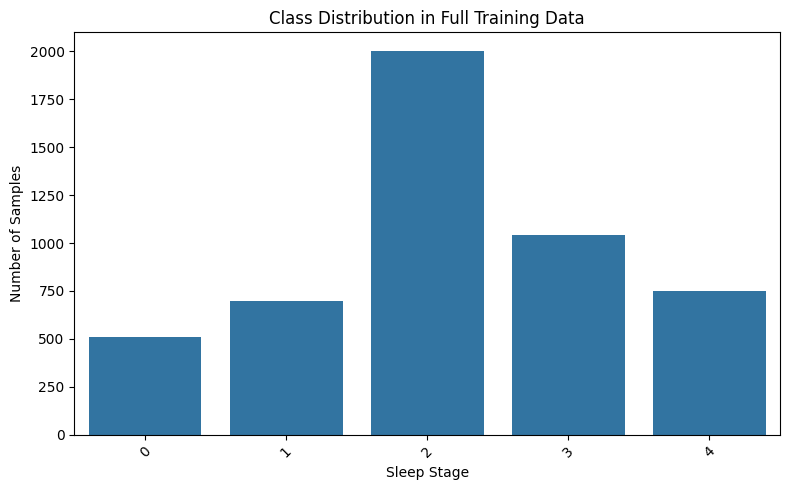


Plotting example signals from each sleep stage:


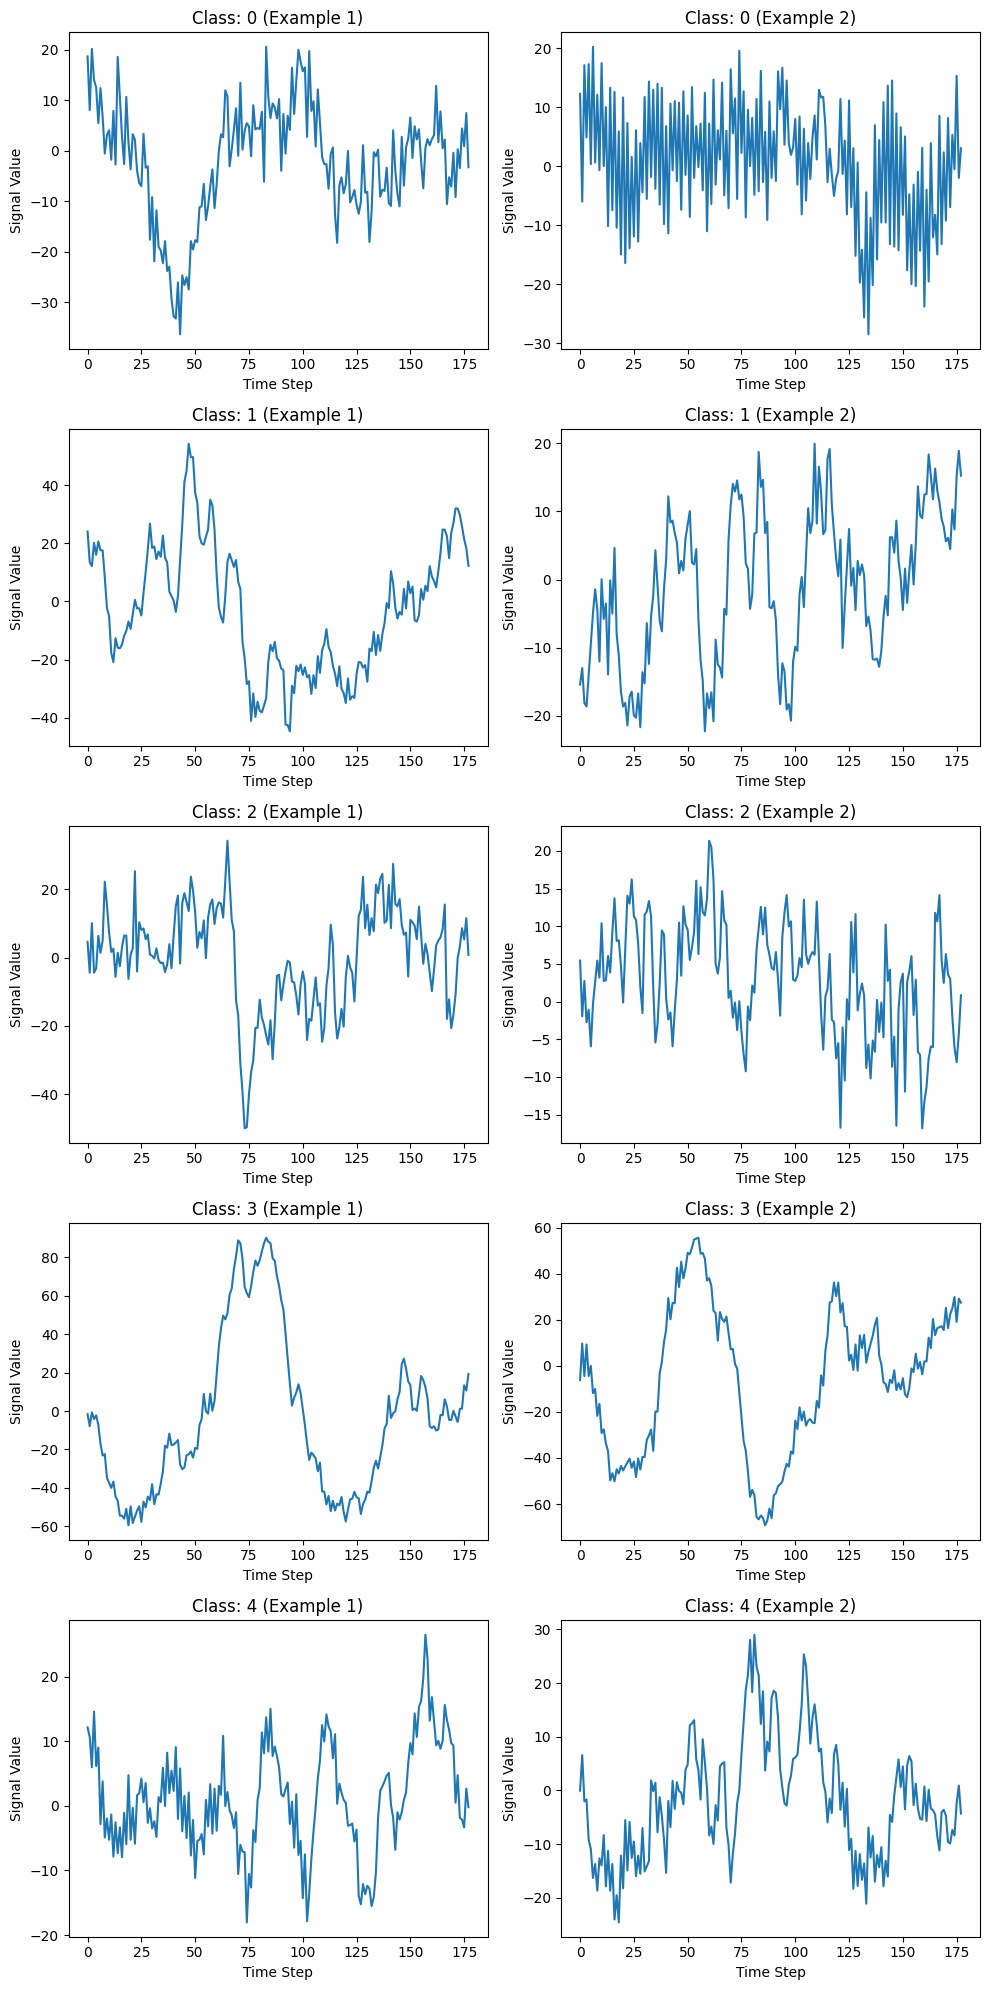

In [73]:
# Prepare data for EDA (using the full raw training set)
X_train_full_eda = train_df.iloc[:, 1:].values
y_train_full_eda_labels = train_df.iloc[:, 0].values # Original string labels

# ---- Helper Function for Basic Data Exploration ----
def explore_data(df, name="Dataset"):
    """Prints basic info and class distribution for a DataFrame (assuming first col is label)."""
    print(f"--- Exploring {name} ---")
    print(f"Shape: {df.shape}")
    print(f"First 5 rows:\n{df.head()}")
    
    # Class distribution (assuming first column is the label)
    label_column = df.columns[0]
    class_counts = df[label_column].value_counts().sort_index()
    print("\nClass Distribution:")
    print(class_counts)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title(f"Class Distribution in {name}")
    plt.xlabel("Sleep Stage")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return class_counts

# ---- Helper Function to Plot Example Signals ----
def plot_examples(X, y_labels, n_examples_per_class=2, random_seed=None):
    """Plots a few example time series signals for each class."""
    if random_seed is not None:
        np.random.seed(random_seed) # For reproducibility of examples

    unique_classes = np.unique(y_labels)
    n_classes = len(unique_classes)
    
    # Determine grid size
    # We want n_examples_per_class plots for each of n_classes
    total_plots = n_classes * n_examples_per_class
    # Aim for a somewhat square layout, or ensure enough rows
    n_cols = min(n_examples_per_class, 3) # Max 3 examples side-by-side
    n_rows = (total_plots + n_cols -1) // n_cols # Calculate needed rows

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
    axs = axs.flatten() # Flatten to easily iterate

    plot_idx = 0
    for i, cls_name in enumerate(unique_classes):
        class_indices = np.where(y_labels == cls_name)[0]
        if len(class_indices) == 0:
            print(f"Warning: No samples found for class {cls_name}")
            continue
            
        # Shuffle indices to get random examples
        np.random.shuffle(class_indices)
        
        # Select n_examples_per_class, or fewer if not enough samples
        selected_indices = class_indices[:min(n_examples_per_class, len(class_indices))]
        
        for k, sample_idx in enumerate(selected_indices):
            if plot_idx < len(axs):
                axs[plot_idx].plot(X[sample_idx, :])
                axs[plot_idx].set_title(f"Class: {cls_name} (Example {k+1})")
                axs[plot_idx].set_xlabel("Time Step")
                axs[plot_idx].set_ylabel("Signal Value")
                plot_idx += 1
            else:
                print("Warning: Ran out of subplot axes for plotting examples.")
                break
        if plot_idx >= len(axs):
            break
            
    # Hide any unused subplots
    for j in range(plot_idx, len(axs)):
        fig.delaxes(axs[j])
        
    plt.tight_layout()
    plt.show()

# %% [markdown]
# **Running EDA Functions:**

# %%
# Explore the raw training dataframe
print("Exploring the full training dataset (train_df):")
train_classes_counts = explore_data(train_df, "Full Training Data")

# %%
# Plot example signals from each class
print("\nPlotting example signals from each sleep stage:")
plot_examples(X_train_full_eda, y_train_full_eda_labels, n_examples_per_class=2, random_seed=SEED) # Using SEED for consistency


# Feature Extraction Functions #

In [74]:

# --- Custom Feature Extraction Functions --- (Paste your functions here)
def extract_stats(X_data):
    features = []
    for signal in X_data:
        mean = np.mean(signal); std = np.std(signal); var = np.var(signal)
        mini = np.min(signal); maxi = np.max(signal); rng = maxi - mini
        median = np.median(signal); skew = 0; kurtosis = 0
        if std > 1e-6: # Avoid division by zero for flat signals
            skew = np.mean(((signal - mean) / std) ** 3)
            kurtosis = np.mean(((signal - mean) / std) ** 4) - 3
        else: # Handle flat signals
            skew = 0
            kurtosis = -3 # Kurtosis of a constant is -3 (excess kurtosis)

        zero_crossings = np.sum(np.diff(np.signbit(signal - np.mean(signal))))
        diff_signal = np.diff(signal)
        peaks = np.sum(np.diff(np.signbit(diff_signal)) < 0  & (diff_signal[:-1] > 0)) # Ensure it's a peak
        diffs = np.diff(signal)
        mean_diff = np.mean(diffs) if len(diffs) > 0 else 0
        std_diff = np.std(diffs) if len(diffs) > 0 else 0
        energy = np.sum(signal ** 2); power = energy / len(signal) if len(signal) > 0 else 0
        q25 = np.percentile(signal, 25); q75 = np.percentile(signal, 75); iqr = q75 - q25
        feat = [mean, std, var, mini, maxi, rng, median, skew, kurtosis,
                zero_crossings, peaks, mean_diff, std_diff, energy, power, q25, q75, iqr]
        features.append(feat)
    return np.array(features)

def extract_fft_features(X_data, n_coeffs=50):
    features = []
    for signal in X_data:
        fft_values_complex = fft(signal)
        fft_values = np.abs(fft_values_complex)
        eff_n_coeffs = min(n_coeffs, len(fft_values) // 2)
        dominant_freqs = fft_values[:eff_n_coeffs]
        if len(dominant_freqs) < n_coeffs:
            dominant_freqs = np.pad(dominant_freqs, (0, n_coeffs - len(dominant_freqs)), 'constant')
        total_power = np.sum(fft_values ** 2)
        total_power = total_power if total_power > 1e-6 else 1.0
        n_bands = 5
        band_size = max(1, len(fft_values) // (2 * n_bands))
        band_powers = []
        for i in range(n_bands):
            start = i * band_size
            end = min((i + 1) * band_size, len(fft_values) // 2)
            if start >= end:
                band_powers.append(0)
                continue
            band_power = np.sum(fft_values[start:end] ** 2) / total_power
            band_powers.append(band_power)
        fft_mean = np.mean(fft_values[:len(fft_values)//2])
        fft_std = np.std(fft_values[:len(fft_values)//2])
        fft_max = np.max(fft_values[:len(fft_values)//2])
        fft_peak_idx = np.argmax(fft_values[:len(fft_values)//2]) if len(fft_values) > 0 else 0
        feat = np.concatenate([dominant_freqs, band_powers, [fft_mean, fft_std, fft_max, fft_peak_idx]])
        features.append(feat)
    return np.array(features)

def extract_wavelet_features(X_data, wavelet='db4', level=4):
    features = []
    expected_feature_length = (level + 1) * 3
    for signal in X_data:
        wavelet_features_single = []
        try:
            min_len = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet))
            actual_level = min(level, min_len)
            if actual_level < 1 :
                 coeffs = []
            else:
                coeffs = pywt.wavedec(signal, wavelet, level=actual_level)
            for i in range(level + 1):
                if i < len(coeffs) and len(coeffs[i]) > 0:
                    coef = coeffs[i]
                    wavelet_features_single.extend([np.mean(coef), np.std(coef), np.sum(coef ** 2)])
                else:
                    wavelet_features_single.extend([0.0, 0.0, 0.0])
        except ValueError:
            wavelet_features_single = [0.0] * expected_feature_length
        if len(wavelet_features_single) < expected_feature_length:
            wavelet_features_single.extend([0.0] * (expected_feature_length - len(wavelet_features_single)))
        elif len(wavelet_features_single) > expected_feature_length:
            wavelet_features_single = wavelet_features_single[:expected_feature_length]
        features.append(wavelet_features_single)
    return np.array(features)

def extract_arima_features(X_data):
    print("Extracting ARIMA features (this may take a very long time)...")
    features = []
    num_arima_feats = 3 + 1 + 1 + 1
    for i, signal in enumerate(X_data):
        if (i + 1) % 100 == 0: print(f"  Processed {i+1}/{len(X_data)} signals for ARIMA features.")
        try:
            model = pm.auto_arima(signal, start_p=1, start_q=1, max_p=3, max_q=3, d=None,
                                  seasonal=False, stepwise=True, suppress_warnings=True,
                                  error_action='ignore', trace=False)
            if model is not None and hasattr(model, 'order'):
                p, d, q = model.order
                aic = model.aic() if hasattr(model, 'aic') else np.nan
                bic = model.bic() if hasattr(model, 'bic') else np.nan
                sigma2 = model.params().get('sigma2', np.nan)
                feat = [p, d, q, aic, bic, sigma2]
            else: feat = [np.nan] * num_arima_feats
        except Exception as e: feat = [np.nan] * num_arima_feats
        features.append(feat)
    arima_features_array = np.array(features)
    if arima_features_array.shape[0] > 0:
        col_means = np.nanmean(arima_features_array, axis=0)
        col_means = np.where(np.isnan(col_means), 0, col_means)
        for j in range(arima_features_array.shape[1]):
            col_data = arima_features_array[:, j]
            arima_features_array[np.isnan(col_data), j] = col_means[j]
    return arima_features_array

def extract_prophet_features(X_data):
    print("Extracting Prophet features (this may also take a long time)...")
    features = []
    num_prophet_feats = 3
    for i, signal in enumerate(X_data):
        if (i + 1) % 100 == 0: print(f"  Processed {i+1}/{len(X_data)} signals for Prophet features.")
        df_prophet = pd.DataFrame({'ds': pd.to_datetime(pd.RangeIndex(start=0, stop=len(signal), step=1), unit='s'), 'y': signal})
        try:
            m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, changepoint_range=0.8)
            m.fit(df_prophet, iter=500)
            growth_rate = m.params['delta'][0][0] if 'delta' in m.params and m.params['delta'].size > 0 else 0.0
            num_changepoints = len(m.changepoints)
            initial_trend = m.params['k'][0][0] if 'k' in m.params and m.params['k'].size > 0 else 0.0
            feat = [growth_rate, num_changepoints, initial_trend]
        except Exception as e: feat = [0.0] * num_prophet_feats
        features.append(feat)
    return np.array(features)

print("Feature extraction functions defined.")

Feature extraction functions defined.


# Data Preparation (Split, Encode, Scale Raw Data) #

In [75]:

X_all_train_raw = train_df.iloc[:, 1:].values
y_all_train_raw = train_df.iloc[:, 0].values
X_test_full_raw = test_df.values

# Ensure test data has consistent number of features as training data
if X_test_full_raw.shape[1] < X_all_train_raw.shape[1]:
    print(f"Padding test data from {X_test_full_raw.shape[1]} to {X_all_train_raw.shape[1]} features.")
    padding = np.zeros((X_test_full_raw.shape[0], X_all_train_raw.shape[1] - X_test_full_raw.shape[1]))
    X_test_full_raw = np.hstack((X_test_full_raw, padding))
elif X_test_full_raw.shape[1] > X_all_train_raw.shape[1]:
    print(f"Truncating test data from {X_test_full_raw.shape[1]} to {X_all_train_raw.shape[1]} features.")
    X_test_full_raw = X_test_full_raw[:, :X_all_train_raw.shape[1]]

le = LabelEncoder()
y_all_train_encoded = le.fit_transform(y_all_train_raw)
num_classes = len(le.classes_)
print(f"Number of unique classes: {num_classes}")
print(f"LabelEncoder classes: {le.classes_}")
# Save LabelEncoder
joblib.dump(le, os.path.join(MODEL_PATH, 'label_encoder.joblib'))
print("LabelEncoder saved.")


X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_all_train_raw, y_all_train_encoded, test_size=0.2, random_state=SEED, stratify=y_all_train_encoded
)
print(f"Raw X_train shape: {X_train_raw.shape}, y_train shape: {y_train.shape}")
print(f"Raw X_val shape: {X_val_raw.shape}, y_val shape: {y_val.shape}")
print(f"Raw X_test_full shape: {X_test_full_raw.shape}")

# Scale raw time series data (for TSF, CNN)
scaler_ts_path = os.path.join(MODEL_PATH, 'scaler_ts.joblib')
if RECOMPUTE_FEATURES or not os.path.exists(scaler_ts_path): # Scaler depends on raw data, so tied to RECOMPUTE_FEATURES
    scaler_ts = StandardScaler()
    X_train_ts_scaled = scaler_ts.fit_transform(X_train_raw)
    joblib.dump(scaler_ts, scaler_ts_path)
    print("TimeSeries Scaler (scaler_ts) fitted and saved.")
else:
    scaler_ts = joblib.load(scaler_ts_path)
    X_train_ts_scaled = scaler_ts.transform(X_train_raw) # Still need to transform current split
    print("TimeSeries Scaler (scaler_ts) loaded.")

X_val_ts_scaled = scaler_ts.transform(X_val_raw)
X_test_ts_scaled = scaler_ts.transform(X_test_full_raw)

print(f"Scaled X_train_ts_scaled shape: {X_train_ts_scaled.shape}")

Number of unique classes: 5
LabelEncoder classes: [0 1 2 3 4]
LabelEncoder saved.
Raw X_train shape: (3999, 178), y_train shape: (3999,)
Raw X_val shape: (1000, 178), y_val shape: (1000,)
Raw X_test_full shape: (1000, 178)
TimeSeries Scaler (scaler_ts) fitted and saved.
Scaled X_train_ts_scaled shape: (3999, 178)


# Feature Engineering Execution & Scaling #

In [76]:

# Define file paths for engineered features
X_train_eng_path = os.path.join(FEATURE_PATH, 'X_train_engineered.npy')
X_val_eng_path = os.path.join(FEATURE_PATH, 'X_val_engineered.npy')
X_test_eng_path = os.path.join(FEATURE_PATH, 'X_test_engineered.npy')
scaler_eng_path = os.path.join(MODEL_PATH, 'scaler_eng.joblib')

if RECOMPUTE_FEATURES:
    print("RECOMPUTE_FEATURES is True. Extracting all features...")
    print("Extracting statistical features...")
    X_train_stats = extract_stats(X_train_raw); X_val_stats = extract_stats(X_val_raw); X_test_stats = extract_stats(X_test_full_raw)
    print("Extracting FFT features...")
    X_train_fft = extract_fft_features(X_train_raw); X_val_fft = extract_fft_features(X_val_raw); X_test_fft = extract_fft_features(X_test_full_raw)
    print("Extracting Wavelet features...")
    X_train_wave = extract_wavelet_features(X_train_raw); X_val_wave = extract_wavelet_features(X_val_raw); X_test_wave = extract_wavelet_features(X_test_full_raw)

    train_feature_sets = [X_train_stats, X_train_fft, X_train_wave]
    val_feature_sets = [X_val_stats, X_val_fft, X_val_wave]
    test_feature_sets = [X_test_stats, X_test_fft, X_test_wave]

    if RUN_ARIMA_FEATURES:
        X_train_arima = extract_arima_features(X_train_raw); train_feature_sets.append(X_train_arima)
        X_val_arima = extract_arima_features(X_val_raw); val_feature_sets.append(X_val_arima)
        X_test_arima = extract_arima_features(X_test_full_raw); test_feature_sets.append(X_test_arima)
    else: print("Skipping ARIMA feature extraction.")

    if RUN_PROPHET_FEATURES:
        X_train_prophet = extract_prophet_features(X_train_raw); train_feature_sets.append(X_train_prophet)
        X_val_prophet = extract_prophet_features(X_val_raw); val_feature_sets.append(X_val_prophet)
        X_test_prophet = extract_prophet_features(X_test_full_raw); test_feature_sets.append(X_test_prophet)
    else: print("Skipping Prophet feature extraction.")

    X_train_engineered = np.hstack(train_feature_sets)
    X_val_engineered = np.hstack(val_feature_sets)
    X_test_engineered = np.hstack(test_feature_sets)

    # Save engineered features
    np.save(X_train_eng_path, X_train_engineered)
    np.save(X_val_eng_path, X_val_engineered)
    np.save(X_test_eng_path, X_test_engineered)
    print("Engineered features computed and saved.")

    scaler_eng = StandardScaler()
    X_train_eng_scaled = scaler_eng.fit_transform(X_train_engineered)
    joblib.dump(scaler_eng, scaler_eng_path)
    print("Engineered Feature Scaler (scaler_eng) fitted and saved.")

else: # Load pre-computed features
    print("RECOMPUTE_FEATURES is False. Attempting to load pre-computed engineered features...")
    if all(os.path.exists(p) for p in [X_train_eng_path, X_val_eng_path, X_test_eng_path, scaler_eng_path]):
        X_train_engineered = np.load(X_train_eng_path)
        X_val_engineered = np.load(X_val_eng_path)
        X_test_engineered = np.load(X_test_eng_path)
        scaler_eng = joblib.load(scaler_eng_path)
        X_train_eng_scaled = scaler_eng.transform(X_train_engineered) # Use transform for consistency, though fit_transform was used originally
        print("Engineered features and scaler loaded successfully.")
    else:
        print("ERROR: Pre-computed feature files or scaler not found. Set RECOMPUTE_FEATURES to True.")
        raise FileNotFoundError("Missing pre-computed feature files or scaler_eng.joblib.")

X_val_eng_scaled = scaler_eng.transform(X_val_engineered)
X_test_eng_scaled = scaler_eng.transform(X_test_engineered)

print(f"Shape of scaled engineered train features: {X_train_eng_scaled.shape}")
print(f"Shape of scaled engineered validation features: {X_val_eng_scaled.shape}")
print(f"Shape of scaled engineered test features: {X_test_eng_scaled.shape}")


# Prepare data for sktime (nested format from scaled raw data)
X_train_nested = from_2d_array_to_nested(X_train_ts_scaled)
X_val_nested = from_2d_array_to_nested(X_val_ts_scaled)
X_test_nested = from_2d_array_to_nested(X_test_ts_scaled)
print(f"Shape of nested train data for sktime: {X_train_nested.shape}")


RECOMPUTE_FEATURES is True. Extracting all features...
Extracting statistical features...
Extracting FFT features...
Extracting Wavelet features...
Skipping ARIMA feature extraction.
Skipping Prophet feature extraction.
Engineered features computed and saved.
Engineered Feature Scaler (scaler_eng) fitted and saved.
Shape of scaled engineered train features: (3999, 92)
Shape of scaled engineered validation features: (1000, 92)
Shape of scaled engineered test features: (1000, 92)
Shape of nested train data for sktime: (3999, 1)


# Model Training & Evaluation #

In [77]:
models = {}
val_accuracies = {}
test_predictions_all = {} # To store test predictions for all models

# For GridSearchCV, ensure consistent folds
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

## Traditional Models on Engineered Features ##

In [78]:

traditional_model_configs = {
    'Logistic Regression': (LogisticRegression(random_state=SEED, max_iter=2000, solver='liblinear', class_weight='balanced'), {}),
    'Random Forest': (RandomForestClassifier(random_state=SEED, n_jobs=-1), # GridSearch done separately below
                      {'param_grid': {
                          'n_estimators': [100, 150], 'max_depth': [10, 20],
                          'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2],
                          'class_weight': ['balanced', 'balanced_subsample']},
                       'use_gridsearch': True}),
    'SVM': (SVC(random_state=SEED, C=1.0, kernel='rbf', class_weight='balanced', probability=True), {}), # probability=True for potential voting
    'Decision Tree': (DecisionTreeClassifier(random_state=SEED, class_weight='balanced', max_depth=10), {}),
    'KNN': (KNeighborsClassifier(n_neighbors=7, n_jobs=-1), {}), # n_neighbors can be tuned
    'AdaBoost': (AdaBoostClassifier(n_estimators=100, random_state=SEED, learning_rate=0.1), {}),
}

for name, (model_template, config) in traditional_model_configs.items():
    model_path = os.path.join(MODEL_PATH, f"{name.lower().replace(' ', '_')}.joblib")
    print(f"\n--- {name} (Eng. Feat.) ---")

    if RECOMPUTE_TRADITIONAL_MODELS or not os.path.exists(model_path):
        print(f"Training {name}...")
        if config.get('use_gridsearch', False):
            print(f"Performing GridSearchCV for {name}...")
            grid_search = GridSearchCV(model_template, config['param_grid'], cv=cv_stratified, scoring='accuracy', verbose=1, n_jobs=-1)
            grid_search.fit(X_train_eng_scaled, y_train)
            print(f"Best params for {name}: {grid_search.best_params_}")
            model_to_fit = grid_search.best_estimator_
        else:
            model_to_fit = model_template
            model_to_fit.fit(X_train_eng_scaled, y_train)
        
        joblib.dump(model_to_fit, model_path)
        models[name] = model_to_fit
        print(f"{name} trained and saved.")
    else:
        print(f"Loading pre-trained {name}...")
        models[name] = joblib.load(model_path)
        print(f"{name} loaded.")

    if models.get(name):
        val_preds = models[name].predict(X_val_eng_scaled)
        acc = accuracy_score(y_val, val_preds)
        val_accuracies[name] = acc
        print(f"{name} - Validation Accuracy: {acc:.4f}")
        # print(classification_report(y_val, val_preds, target_names=[str(c) for c in le.classes_], zero_division=0))




--- Logistic Regression (Eng. Feat.) ---
Training Logistic Regression...
Logistic Regression trained and saved.
Logistic Regression - Validation Accuracy: 0.6370

--- Random Forest (Eng. Feat.) ---
Training Random Forest...
Performing GridSearchCV for Random Forest...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params for Random Forest: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Random Forest trained and saved.
Random Forest - Validation Accuracy: 0.6790

--- SVM (Eng. Feat.) ---
Training SVM...
SVM trained and saved.
SVM - Validation Accuracy: 0.6650

--- Decision Tree (Eng. Feat.) ---
Training Decision Tree...
Decision Tree trained and saved.
Decision Tree - Validation Accuracy: 0.5730

--- KNN (Eng. Feat.) ---
Training KNN...
KNN trained and saved.
KNN - Validation Accuracy: 0.6300

--- AdaBoost (Eng. Feat.) ---
Training AdaBoost...
AdaBoost trained and saved.
AdaBoost - Validatio

## XGBoost with GridSearchCV ##

In [79]:

xgb_model_path = os.path.join(MODEL_PATH, 'xgboost_tuned.joblib')
print("\n--- XGBoost (Eng. Feat. - Tuned) ---")

if RECOMPUTE_XGBOOST_GRIDSEARCH or not os.path.exists(xgb_model_path):
    print("Training XGBoost with GridSearchCV (this might take time)...")
    param_grid_xgb = {
        'n_estimators': [200, 300], # Reduced for speed in example, expand for full search [200, 300, 400]
        'learning_rate': [0.05, 0.1], # [0.03, 0.05, 0.1]
        'max_depth': [5, 7], # [5, 7, 9]
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'gamma': [0, 0.1],
        'min_child_weight': [1, 3]
    }
    # Calculate class weights for XGBoost if classes are imbalanced.
    # This is an alternative to scale_pos_weight for multi-class or can be used to inform it.
    # classes_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    # sample_weights_xgb = np.array([classes_weights[cls] for cls in y_train])
    # print("Sample weights computed for XGBoost based on class imbalance.")

    xgb_grid_search = GridSearchCV(
        XGBClassifier(random_state=SEED, eval_metric='mlogloss', use_label_encoder=False),
        param_grid_xgb,
        cv=cv_stratified,
        scoring='accuracy',
        verbose=1, # Set to 1 or 2 for more output
        n_jobs=-1
    )
    # xgb_grid_search.fit(X_train_eng_scaled, y_train, sample_weight=sample_weights_xgb) # If using sample_weight
    xgb_grid_search.fit(X_train_eng_scaled, y_train)


    print(f"Best XGBoost params: {xgb_grid_search.best_params_}")
    print(f"Best XGBoost CV accuracy: {xgb_grid_search.best_score_:.4f}")
    xgb_clf_tuned = xgb_grid_search.best_estimator_
    joblib.dump(xgb_clf_tuned, xgb_model_path)
    models['XGBoost (Tuned)'] = xgb_clf_tuned
    print("Tuned XGBoost trained and saved.")
else:
    print("Loading pre-trained Tuned XGBoost...")
    models['XGBoost (Tuned)'] = joblib.load(xgb_model_path)
    print("Tuned XGBoost loaded.")

if models.get('XGBoost (Tuned)'):
    val_preds_xgb = models['XGBoost (Tuned)'].predict(X_val_eng_scaled)
    acc_xgb = accuracy_score(y_val, val_preds_xgb)
    val_accuracies['XGBoost (Tuned)'] = acc_xgb
    print(f"XGBoost (Tuned) - Validation Accuracy: {acc_xgb:.4f}")
    # print(classification_report(y_val, val_preds_xgb, target_names=[str(c) for c in le.classes_], zero_division=0))



--- XGBoost (Eng. Feat. - Tuned) ---
Training XGBoost with GridSearchCV (this might take time)...
Fitting 3 folds for each of 128 candidates, totalling 384 fits


C:\Users\Semhane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [03:07:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}
Best XGBoost CV accuracy: 0.7069
Tuned XGBoost trained and saved.
XGBoost (Tuned) - Validation Accuracy: 0.7020


##  TimeSeries Forest on Raw Scaled Time Series ##

In [80]:
tsf_model_path = os.path.join(MODEL_PATH, 'timeseries_forest.joblib')
print("\n--- TimeSeries Forest (Raw TS) ---")

if RECOMPUTE_TRADITIONAL_MODELS or not os.path.exists(tsf_model_path): # Grouped with traditional for convenience
    print("Training TimeSeries Forest...")
    ts_forest = TimeSeriesForestClassifier(n_estimators=150, random_state=SEED, n_jobs=-1) # Can be tuned
    ts_forest.fit(X_train_nested, y_train)
    joblib.dump(ts_forest, tsf_model_path)
    models['TimeSeries Forest'] = ts_forest
    print("TimeSeries Forest trained and saved.")
else:
    print("Loading pre-trained TimeSeries Forest...")
    models['TimeSeries Forest'] = joblib.load(tsf_model_path)
    print("TimeSeries Forest loaded.")

if models.get('TimeSeries Forest'):
    val_preds_tsf = models['TimeSeries Forest'].predict(X_val_nested)
    acc_tsf = accuracy_score(y_val, val_preds_tsf)
    val_accuracies['TimeSeries Forest'] = acc_tsf
    print(f"TimeSeries Forest - Validation Accuracy: {acc_tsf:.4f}")
    # print(classification_report(y_val, val_preds_tsf, target_names=[str(c) for c in le.classes_], zero_division=0))



--- TimeSeries Forest (Raw TS) ---
Training TimeSeries Forest...
TimeSeries Forest trained and saved.
TimeSeries Forest - Validation Accuracy: 0.5660


##  1D Convolutional Neural Network (CNN) with Optuna Tuning ##

In [ ]:
# Determine device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing PyTorch device: {device}")

# Prepare PyTorch Tensors (using already scaled raw data)
X_train_cnn_opt = torch.tensor(X_train_ts_scaled.reshape(-1, 1, X_train_ts_scaled.shape[1]), dtype=torch.float32)
y_train_cnn_opt = torch.tensor(y_train, dtype=torch.long)
X_val_cnn_opt = torch.tensor(X_val_ts_scaled.reshape(-1, 1, X_val_ts_scaled.shape[1]), dtype=torch.float32)
y_val_cnn_opt = torch.tensor(y_val, dtype=torch.long)
X_test_cnn_tensor = torch.tensor(X_test_ts_scaled.reshape(-1, 1, X_test_ts_scaled.shape[1]), dtype=torch.float32) # For final prediction

num_input_features_cnn_global = X_train_ts_scaled.shape[1]
num_classes_global = num_classes

# --- CNN Definition (Paste your CNN1D class here) ---
class CNN1D(nn.Module):
    def __init__(self, num_features_in, num_classes_out, n_filters_1, n_filters_2, n_filters_3, fc_units, dropout_rate):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_filters_1, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(n_filters_1); self.relu1 = nn.ReLU(); self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(n_filters_1, n_filters_2, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(n_filters_2); self.relu2 = nn.ReLU(); self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.conv3 = nn.Conv1d(n_filters_2, n_filters_3, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm1d(n_filters_3); self.relu3 = nn.ReLU(); self.pool3 = nn.MaxPool1d(kernel_size=2)
        with torch.no_grad(): # Dynamic flattening size calculation
            dummy = torch.randn(1, 1, num_features_in)
            dummy = self.pool1(self.relu1(self.bn1(self.conv1(dummy))))
            dummy = self.pool2(self.relu2(self.bn2(self.conv2(dummy))))
            dummy = self.pool3(self.relu3(self.bn3(self.conv3(dummy))))
            flattened_size = dummy.shape[1] * dummy.shape[2]
        self.flatten = nn.Flatten(); self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(flattened_size, fc_units); self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(fc_units, num_classes_out)
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x)))); x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x)))); x = self.flatten(x); x = self.dropout(x)
        x = self.relu4(self.fc1(x)); x = self.fc2(x)
        return x
print("CNN1D class defined.")

# --- Optuna Objective Function (Paste your objective_cnn function here) ---
def objective_cnn(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True) # Adjusted range
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.6) # Adjusted range
    batch_size = trial.suggest_categorical("batch_size", [32, 64]) # Reduced options
    n_filters_1 = trial.suggest_categorical("n_filters_1", [32, 64])
    n_filters_2 = trial.suggest_categorical("n_filters_2", [64, 128])
    n_filters_3 = trial.suggest_categorical("n_filters_3", [128, 256])
    fc_units = trial.suggest_categorical("fc_units", [128, 256]) # Reduced options
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.15) # Adjusted range

    model = CNN1D(num_input_features_cnn_global, num_classes_global, n_filters_1, n_filters_2, n_filters_3, fc_units, dropout_rate).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Class weights for CrossEntropyLoss (calculated once outside if y_train is static)
    # classes_weights_torch = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32).to(device)
    # criterion = nn.CrossEntropyLoss(weight=classes_weights_torch, label_smoothing=label_smoothing)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)


    train_dataset_opt = TensorDataset(X_train_cnn_opt, y_train_cnn_opt)
    val_dataset_opt = TensorDataset(X_val_cnn_opt, y_val_cnn_opt)
    train_loader_opt = DataLoader(train_dataset_opt, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True if device.type == 'cuda' else False)
    val_loader_opt = DataLoader(val_dataset_opt, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True if device.type == 'cuda' else False)

    num_epochs_optuna_trial = 30 # Shorter epochs for Optuna trials
    best_val_acc_trial = 0.0; patience_optuna_trial = 7; patience_counter_trial = 0

    for epoch in range(num_epochs_optuna_trial):
        model.train()
        for inputs, labels in train_loader_opt:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
        model.eval(); correct = 0; total = 0
        with torch.no_grad():
            for inputs, labels in val_loader_opt:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs); _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0); correct += (predicted == labels).sum().item()
        epoch_val_acc = correct / total
        if epoch_val_acc > best_val_acc_trial: best_val_acc_trial = epoch_val_acc; patience_counter_trial = 0
        else: patience_counter_trial += 1
        if patience_counter_trial >= patience_optuna_trial: break
        trial.report(epoch_val_acc, epoch)
        if trial.should_prune(): raise optuna.exceptions.TrialPruned()
    return best_val_acc_trial
print("Optuna objective_cnn function defined.")

# --- Run Optuna Study ---
best_cnn_params_path = os.path.join(MODEL_PATH, 'best_cnn_optuna_params.joblib')
best_cnn_params = None

if RECOMPUTE_CNN_OPTUNA:
    print("\nStarting Optuna study for 1D-CNN hyperparameter tuning...")
    study_cnn = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study_cnn.optimize(objective_cnn, n_trials=20, timeout=3600) # n_trials or timeout
    print("Optuna study finished.")
    best_trial_cnn = study_cnn.best_trial
    best_cnn_params = best_trial_cnn.params
    joblib.dump(best_cnn_params, best_cnn_params_path)
    print(f"Best CNN trial value (Val Acc): {best_trial_cnn.value:.4f}")
    print(f"Best CNN params saved: {best_cnn_params}")
else:
    print("\nSkipping Optuna study.")
    if os.path.exists(best_cnn_params_path):
        best_cnn_params = joblib.load(best_cnn_params_path)
        print(f"Loaded best CNN Optuna params: {best_cnn_params}")
    else:
        print("No pre-computed Optuna params found. Using default CNN params for final training if RECOMPUTE_FINAL_CNN is True.")
        # Define some default parameters if Optuna wasn't run and no file exists
        best_cnn_params = { # These are from your original script or a reasonable default
            'lr': 0.0005, 'weight_decay': 1e-4, 'dropout_rate': 0.5, 'batch_size': 64,
            'n_filters_1': 32, 'n_filters_2': 64, 'n_filters_3': 128, 'fc_units': 256,
            'label_smoothing': 0.0 # Or a small value like 0.1
        }
        print(f"Using default CNN params: {best_cnn_params}")

# --- Train final CNN model with best (or default) Optuna hyperparameters ---
final_cnn_model_path = os.path.join(MODEL_PATH, 'best_tuned_cnn_1d_model.pth')
final_cnn_model = None

if RECOMPUTE_FINAL_CNN and best_cnn_params is not None:
    print("\nTraining final 1D-CNN with determined hyperparameters...")
    final_cnn_model = CNN1D(
        num_features_in=num_input_features_cnn_global, num_classes_out=num_classes_global,
        n_filters_1=best_cnn_params['n_filters_1'], n_filters_2=best_cnn_params['n_filters_2'],
        n_filters_3=best_cnn_params['n_filters_3'], fc_units=best_cnn_params['fc_units'],
        dropout_rate=best_cnn_params['dropout_rate']
    ).to(device)
    
    if num_input_features_cnn_global > 0: # Only print summary if model can be built
        try:
            summary(final_cnn_model, input_size=(1, num_input_features_cnn_global))
        except Exception as e:
            print(f"Could not print model summary: {e}")

    final_optimizer = optim.AdamW(final_cnn_model.parameters(), lr=best_cnn_params['lr'], weight_decay=best_cnn_params['weight_decay'])
    # classes_weights_torch_final = torch.tensor(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32).to(device)
    # final_criterion = nn.CrossEntropyLoss(weight=classes_weights_torch_final, label_smoothing=best_cnn_params['label_smoothing'])
    final_criterion = nn.CrossEntropyLoss(label_smoothing=best_cnn_params.get('label_smoothing', 0.0))


    final_batch_size = best_cnn_params['batch_size']
    train_dataset_final = TensorDataset(X_train_cnn_opt, y_train_cnn_opt)
    val_dataset_final = TensorDataset(X_val_cnn_opt, y_val_cnn_opt)
    train_loader_final = DataLoader(train_dataset_final, batch_size=final_batch_size, shuffle=True, num_workers=2, pin_memory=True if device.type == 'cuda' else False)
    val_loader_final = DataLoader(val_dataset_final, batch_size=final_batch_size, shuffle=False, num_workers=2, pin_memory=True if device.type == 'cuda' else False)

    num_epochs_cnn_final = 100 # Potentially more epochs for final model
    best_val_acc_cnn_final = 0.0; patience_cnn_final = 20; patience_counter_cnn_final = 0
    scheduler_final = optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode='max', patience=7, factor=0.5, verbose=True) # Schedule on val_acc

    for epoch in range(num_epochs_cnn_final):
        final_cnn_model.train(); running_loss = 0.0
        for inputs, labels in train_loader_final:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            final_optimizer.zero_grad(); outputs = final_cnn_model(inputs); loss = final_criterion(outputs, labels)
            loss.backward(); final_optimizer.step(); running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader_final.dataset)

        final_cnn_model.eval(); val_loss = 0.0; correct = 0; total = 0
        with torch.no_grad():
            for inputs, labels in val_loader_final:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = final_cnn_model(inputs); loss_v = final_criterion(outputs, labels)
                val_loss += loss_v.item() * inputs.size(0); _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0); correct += (predicted == labels).sum().item()
        epoch_val_loss = val_loss / len(val_loader_final.dataset)
        epoch_val_acc = correct / total
        print(f"Final CNN Epoch {epoch+1}/{num_epochs_cnn_final}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, LR: {final_optimizer.param_groups[0]['lr']:.1e}")
        scheduler_final.step(epoch_val_acc)
        if epoch_val_acc > best_val_acc_cnn_final:
            best_val_acc_cnn_final = epoch_val_acc
            torch.save(final_cnn_model.state_dict(), final_cnn_model_path)
            print(f"  New best tuned CNN val acc: {best_val_acc_cnn_final:.4f}. Model saved.")
            patience_counter_cnn_final = 0
        else: patience_counter_cnn_final += 1
        if patience_counter_cnn_final >= patience_cnn_final: print(f"  Final CNN Early stopping at epoch {epoch+1}."); break
    
    models['1D-CNN (Tuned)'] = final_cnn_model # Store the in-memory model
    val_accuracies['1D-CNN (Tuned)'] = best_val_acc_cnn_final
    print(f"Best Tuned 1D-CNN Validation Accuracy after final training: {best_val_acc_cnn_final:.4f}")

elif os.path.exists(final_cnn_model_path) and best_cnn_params is not None:
    print(f"\nLoading pre-trained final 1D-CNN model from {final_cnn_model_path}...")
    final_cnn_model = CNN1D( # Reconstruct model with saved params to load state_dict
        num_features_in=num_input_features_cnn_global, num_classes_out=num_classes_global,
        n_filters_1=best_cnn_params['n_filters_1'], n_filters_2=best_cnn_params['n_filters_2'],
        n_filters_3=best_cnn_params['n_filters_3'], fc_units=best_cnn_params['fc_units'],
        dropout_rate=best_cnn_params['dropout_rate']
    ).to(device)
    final_cnn_model.load_state_dict(torch.load(final_cnn_model_path, map_location=device))
    models['1D-CNN (Tuned)'] = final_cnn_model
    # To get val_accuracy, you'd need to re-evaluate or save it alongside the model
    # For simplicity, let's re-evaluate if loaded and not computed in this session
    final_cnn_model.eval(); correct = 0; total = 0
    val_dataset_final_eval = TensorDataset(X_val_cnn_opt, y_val_cnn_opt) # Recreate for safety
    val_loader_final_eval = DataLoader(val_dataset_final_eval, batch_size=best_cnn_params.get('batch_size', 64), shuffle=False)
    with torch.no_grad():
        for inputs, labels in val_loader_final_eval:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = final_cnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loaded_cnn_val_acc = correct / total if total > 0 else 0.0
    val_accuracies['1D-CNN (Tuned)'] = loaded_cnn_val_acc
    print(f"Loaded 1D-CNN (Tuned) - Validation Accuracy: {loaded_cnn_val_acc:.4f}")
else:
    print("\nSkipping final CNN training or final CNN model file not found.")



Using PyTorch device: cpu
CNN1D class defined.
Optuna objective_cnn function defined.

Starting Optuna study for 1D-CNN hyperparameter tuning...


# Final Predictions on Test Set & Submission File Generation #

In [ ]:

print("\n--- Predicting on Test Set & Saving Results ---")
# Ensure label encoder `le` is loaded if not in current session memory
if 'le' not in locals() and os.path.exists(os.path.join(MODEL_PATH, 'label_encoder.joblib')):
    le = joblib.load(os.path.join(MODEL_PATH, 'label_encoder.joblib'))
    print("LabelEncoder re-loaded for predictions.")
elif 'le' not in locals():
    print("ERROR: LabelEncoder 'le' not available for inverse transform. Re-run data prep or ensure it's loaded.")
    raise ValueError("LabelEncoder not found.")


for name, model_object in models.items():
    if model_object is None:
        print(f"Skipping predictions for {name} as model is None.")
        continue

    filename_prefix = name.lower().replace('(tuned)', 'tuned').replace('(eng. feat.)', 'eng_feat') \
                                .replace('(raw ts)', 'raw_ts').replace(' ', '_').replace('(', '').replace(')', '')
    preds_original_labels = None
    print(f"Generating predictions for: {name}")

    if name == 'TimeSeries Forest':
        test_preds_encoded = model_object.predict(X_test_nested)
    elif '1D-CNN' in name: # Handles '1D-CNN (Tuned)'
        model_object.eval()
        cnn_test_preds_list = []
        # Ensure test_loader_cnn uses the batch size from the best CNN params if available
        cnn_batch_size_pred = best_cnn_params.get('batch_size', 64) if 'best_cnn_params' in locals() and best_cnn_params else 64
        test_dataset_cnn_pred = TensorDataset(X_test_cnn_tensor)
        test_loader_cnn_pred = DataLoader(test_dataset_cnn_pred, batch_size=cnn_batch_size_pred, shuffle=False)

        with torch.no_grad():
            for inputs_batch in test_loader_cnn_pred: # inputs_batch is a list or tuple
                inputs_tensor = inputs_batch[0].to(device) # Actual tensor is the first element
                outputs = model_object(inputs_tensor)
                _, predicted = torch.max(outputs.data, 1)
                cnn_test_preds_list.extend(predicted.cpu().numpy())
        test_preds_encoded = np.array(cnn_test_preds_list)
    else: # Models trained on engineered features
        test_preds_encoded = model_object.predict(X_test_eng_scaled)

    preds_original_labels = le.inverse_transform(test_preds_encoded)
    test_predictions_all[name] = preds_original_labels # Store for potential ensembling

    # Save individual prediction files
    submission_df = pd.DataFrame(preds_original_labels)
    submission_df.to_csv(f"{filename_prefix}_predictions.csv", index=False, header=False)
    print(f"  Saved: {filename_prefix}_predictions.csv (Shape: {submission_df.shape})")


# Results Summary and Analysis #

In [ ]:

print("\n--- Final Validation Accuracies Summary ---")
if val_accuracies:
    sorted_val_accuracies = sorted(val_accuracies.items(), key=lambda item: item[1], reverse=True)
    for model_name, acc in sorted_val_accuracies:
        print(f"{model_name}: {acc:.4f}")

    best_model_name_val = sorted_val_accuracies[0][0]
    best_model_accuracy_val = sorted_val_accuracies[0][1]
    print(f"\nBest performing model on VALIDATION set: {best_model_name_val} with accuracy: {best_model_accuracy_val:.4f}")
else:
    print("No validation accuracies recorded. Ensure models were trained/evaluated.")

